In [8]:
df.columns

Index(['datetime', 'post_s', 'cmt_s_mean', 'abs_sent_gap', 'aligned_cnt_3h',
       'aligned_cnt_6h', 'aligned_cnt_9h', 'viewCount', 'likeCount',
       'comment_cnt', 'subscriberCount', 'channel', 'Event', 'Event_words',
       'Cause', 'Cause_words', 'Impact', 'Impact_words', 'Reaction',
       'Reaction_words', 'Entity', 'Entity_words', 'match_sum', 'channelTitle',
       'Lnorm', 'L_flag'],
      dtype='object')

In [11]:
import pandas as pd

# 파일 경로 지정
excel_file_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\백업\total_result_data_251119.xlsx"

# 엑셀 파일 불러오기
total_result_df = pd.read_excel(excel_file_path)

# entity, keyword, label, strength 컬럼을 issue와 content_id 별로 그룹핑
grouped_df = total_result_df.groupby(['issue', 'content_id'])[['entity', 'keyword', 'label', 'strength']].agg(lambda x: list(x)).reset_index()

# strength 컬럼명을 'D'로 변경
grouped_df = grouped_df.rename(columns={'strength': 'D'})

# 각 이슈별로 파일이 있을 것으로 가정 ('GS', 'KT', 'SKT', '롯데')
issue_list = ["GS", "KT", "SKT", "롯데"]

# 병합 결과 데이터프레임을 모두 담을 리스트
all_merged = []

for issue in issue_list:
    # 이슈에 해당하는 파일 읽기
    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{issue}_final_merged_L_Lnorm_E_T.xlsx"
    df = pd.read_excel(file_path)

    # 해당 이슈에 맞는 grouped_df에서 content_id를 기준으로 병합
    merged_df = df.merge(
        grouped_df[grouped_df['issue'] == issue][['content_id', 'entity', 'keyword', 'label', 'D']],
        how='left',
        on='content_id'
    )

    # 이슈명 컬럼 만약 없음 추가
    if 'issue' not in merged_df.columns:
        merged_df['issue'] = issue

    # 병합된 결과를 리스트에 추가
    all_merged.append(merged_df)

    # 개별 파일도 별도로 저장 (선택적)
    save_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{issue}_merged_result.xlsx"
    merged_df.to_excel(save_path, index=False)

    # 병합 결과 출력 (여기서는 상위 5개만 예시로 출력)
    print(f"==== {issue} ====")
    print(merged_df.head())
    print(f"저장 완료: {save_path}")

# 네 이슈를 하나로 합치기
total_merged_df = pd.concat(all_merged, axis=0, ignore_index=True)

# 전체 병합 파일 저장
total_save_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result.xlsx"
total_merged_df.to_excel(total_save_path, index=False)
print(f"==== 전체 병합 파일 저장 완료: {total_save_path} ====")
print(total_merged_df.head())


==== GS ====
  issue  content_id            datetime post_sentiment  post_s  cmt_s_mean  \
0    GS         143 2025-02-28 12:02:37             부정    -1.0        -1.0   
1    GS         143 2025-02-28 12:02:37             부정    -1.0        -1.0   
2    GS          19 2025-01-06 23:37:15             부정    -1.0        -1.0   
3    GS         128 2025-02-28 02:34:23             부정    -1.0        -1.0   
4    GS         130 2025-02-28 02:42:43             부정    -1.0         0.0   

   abs_sent_gap  aligned_cnt_3h  aligned_cnt_6h  aligned_cnt_9h  ...  \
0           0.0             1.0             1.0             1.0  ...   
1           0.0             1.0             1.0             1.0  ...   
2           0.0             0.0             1.0             1.0  ...   
3           0.0             1.0             1.0             1.0  ...   
4           1.0             0.0             0.0             0.0  ...   

          R         S         L     Lnorm         E         T    entity  \
0  0.69314

In [5]:
import pandas as pd

company_list = ["GS", "KT", "SKT", "롯데"]

for company in company_list:
    # --------------------------------------------------------
    # 1️⃣ 파일 읽기
    # --------------------------------------------------------
    file_path = rf"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\{company}_with_Lflag.xlsx"
    df = pd.read_excel(file_path)

    # --------------------------------------------------------
    # 2-1️⃣ aligned_cnt_6h 자료형 변환 (object → float)
    # --------------------------------------------------------
    if 'aligned_cnt_6h' in df.columns:
        if df['aligned_cnt_6h'].dtype == 'object':
            df['aligned_cnt_6h'] = pd.to_numeric(df['aligned_cnt_6h'], errors='coerce')

    # --------------------------------------------------------
    # 2-2️⃣ 불필요 컬럼 제거
    # --------------------------------------------------------
    df = df.drop(columns=[
        'abs_sent_gap', 'subscriberCount', 'Event_words', 'channelTitle',
        'content_id', 'issue', 'post_sentiment', '언론사', 'content', 'title_or_text',
        'R', 'S', 'L', 'E', 'T',
        'Cause_words', 'Impact_words', 'Reaction_words', 'Entity_words'
    ], errors='ignore')

    print(f"==== {company} ====")
    print(df.info())

    # --------------------------------------------------------
    # 3️⃣ datetime 변환 + 오름차순 정렬
    # --------------------------------------------------------
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df = df.sort_values('datetime')
    df['datetime_3h'] = df['datetime'].dt.floor('3h')

    # --------------------------------------------------------
    # 4️⃣ Lflag 생성
    # --------------------------------------------------------
    df['Lflag'] = df['channel'].apply(
        lambda x: 1 if str(x).strip() in ['네이버', '뉴스', '커뮤니티'] else 0
    )

    # --------------------------------------------------------
    # 5️⃣ 집계 컬럼 구분
    # --------------------------------------------------------
    sum_cols = [
        'viewCount', 'likeCount', 'comment_cnt',
        'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h', 'match_sum'
    ]
    mean_cols = ['post_s', 'cmt_s_mean']  # ✅ Lnorm은 별도 처리
    sum_cols_valid = [c for c in sum_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    mean_cols_valid = [c for c in mean_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    first_cols = []
    for col in ['Entity', 'Event', 'Cause', 'Impact', 'Reaction', 'Lflag']:
        if col in df.columns:
            first_cols.append(col)

    # --------------------------------------------------------
    # 6️⃣ 기본 그룹핑 (건수 포함)
    # --------------------------------------------------------
    agg_dict = {}
    agg_dict.update({c: 'sum' for c in sum_cols_valid})
    agg_dict.update({c: 'mean' for c in mean_cols_valid})
    agg_dict.update({c: 'first' for c in first_cols})
    agg_dict.update({'datetime': 'count'})   # ✅ 그룹 내 건수 추가

    df_grouped = (
        df.groupby(['datetime_3h', 'channel'])
          .agg(agg_dict)
          .reset_index()
          .rename(columns={'datetime': 'count'})   # count 컬럼명 명확히
    )

    # --------------------------------------------------------
    # 7️⃣ Lnorm 조건부 평균 (트위터·블로그 제외)
    # --------------------------------------------------------
    lnorm_data = (
        df[~df['channel'].isin(['트위터', '블로그'])]
        .groupby(['datetime_3h', 'channel'])['Lnorm']
        .mean()
        .reset_index()
    )

    df_grouped = pd.merge(
        df_grouped,
        lnorm_data,
        on=['datetime_3h', 'channel'],
        how='left',
        suffixes=('', '_filtered')
    )

    if 'Lnorm_filtered' in df_grouped.columns:
        df_grouped['Lnorm'] = df_grouped['Lnorm_filtered']
        df_grouped = df_grouped.drop(columns=['Lnorm_filtered'])

    # --------------------------------------------------------
    # 8️⃣ 저장
    # --------------------------------------------------------
    save_path = f"{company}_3시간_단위_채널별_집계_withCount_1117.xlsx"
    df_grouped.to_excel(save_path, index=False)
    print(f"✅ {company}: 3시간 단위 + 채널별 집계 (Lflag 포함 / Lnorm 필터링 평균 / 건수 포함) 저장 완료 → {save_path}")


==== GS ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        268 non-null    datetime64[ns]
 1   post_s          188 non-null    float64       
 2   cmt_s_mean      188 non-null    float64       
 3   aligned_cnt_3h  188 non-null    float64       
 4   aligned_cnt_6h  188 non-null    float64       
 5   aligned_cnt_9h  188 non-null    float64       
 6   viewCount       17 non-null     float64       
 7   likeCount       17 non-null     float64       
 8   comment_cnt     188 non-null    float64       
 9   channel         268 non-null    object        
 10  Event           268 non-null    int64         
 11  Cause           268 non-null    int64         
 12  Impact          268 non-null    int64         
 13  Reaction        268 non-null    int64         
 14  Entity          268 non-null    int64        

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime_3h     294 non-null    datetime64[ns]
 1   channel         294 non-null    object        
 2   viewCount       294 non-null    int64         
 3   likeCount       294 non-null    int64         
 4   comment_cnt     294 non-null    int64         
 5   aligned_cnt_3h  294 non-null    int64         
 6   aligned_cnt_6h  294 non-null    int64         
 7   aligned_cnt_9h  294 non-null    int64         
 8   match_sum       294 non-null    int64         
 9   post_s          207 non-null    float64       
 10  cmt_s_mean      207 non-null    float64       
 11  Entity          294 non-null    int64         
 12  Event           294 non-null    int64         
 13  Cause           294 non-null    int64         
 14  Impact          294 non-null    int64         
 15  Reacti

In [3]:
# total_merged_result.xlsx 파일을 읽고, issue별 content_id 중복 데이터를 제거하여 출력합니다.
import pandas as pd

excel_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result.xlsx"
df_total = pd.read_excel(excel_path)
print("원본 데이터 shape:", df_total.shape)

# issue별 content_id 중복 제거
df_total_nodup = df_total.drop_duplicates(subset=['issue', 'content_id'])
print("issue별 content_id 중복 제거 후 shape:", df_total_nodup.shape)

# 데이터 미리보기
display(df_total_nodup.head())


원본 데이터 shape: (4386, 40)
issue별 content_id 중복 제거 후 shape: (4380, 40)


,issue,content_id,datetime,post_sentiment,post_s,cmt_s_mean,abs_sent_gap,aligned_cnt_3h,aligned_cnt_6h,aligned_cnt_9h,...,R,S,L,Lnorm,E,T,entity,keyword,label,D
0,GS,143,2025-02-28 12:02:37,부정,-1.0,-1.000000,0.00,1.0,1,1.0,...,0.693147,7.507635,1.695531,0.390761,0.511628,0.520833,['GS 리테일'],['GS홈쇼핑'],['Entity'],[0.0]
2,GS,19,2025-01-06 23:37:15,부정,-1.0,-1.000000,0.00,0.0,1,1.0,...,0.597253,NaN,0.567510,0.730619,0.500000,0.729167,['GS리테일'],['해킹'],['Event'],[0.996]
3,GS,128,2025-02-28 02:34:23,부정,-1.0,-1.000000,0.00,1.0,1,1.0,...,0.597253,NaN,0.567510,0.730619,0.500000,0.729167,['GS리테일'],['유출'],['Event'],[0.991]
4,GS,130,2025-02-28 02:42:43,부정,-1.0,0.000000,1.00,0.0,0,0.0,...,0.597253,NaN,0.567510,0.730619,0.500000,0.729167,['GS리테일'],['유출'],['Event'],[0.993]
6,GS,13,2025-01-06 23:23:09,부정,-1.0,-0.416667,0.58,6.0,6,6.0,...,0.726118,NaN,0.640602,0.826122,0.416667,0.854167,['GS더프레시'],['피해'],['Impact'],[0.628]



====== Issue: GS ======



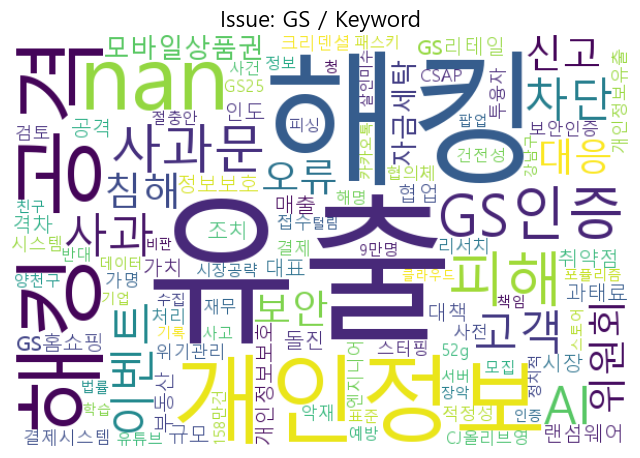

[Issue: GS] Top 3 Keywords


,Keyword,Count
0,유출,57
1,해킹,56
2,해킹 공격,18



====== Issue: KT ======



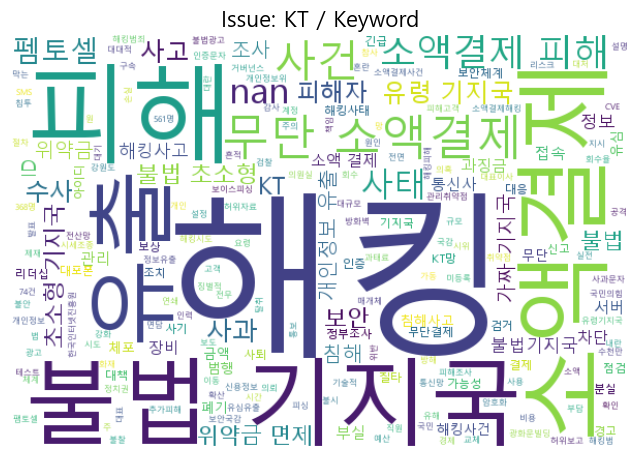

[Issue: KT] Top 3 Keywords


,Keyword,Count
0,해킹,200
1,피해,49
2,불법 기지국,32



====== Issue: SKT ======



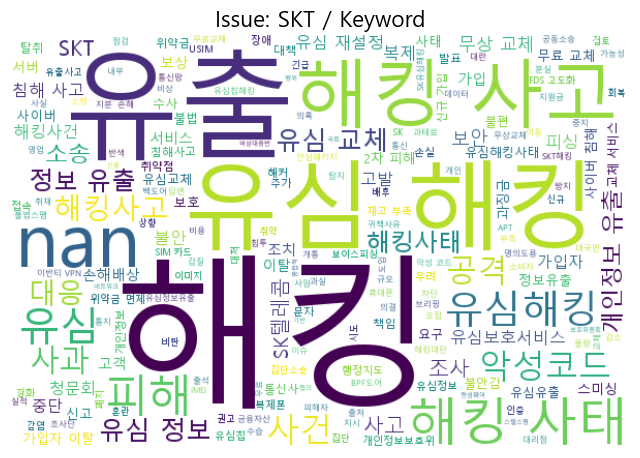

[Issue: SKT] Top 3 Keywords


,Keyword,Count
0,해킹,584
1,유출,227
2,유심 해킹,110



====== Issue: 롯데 ======



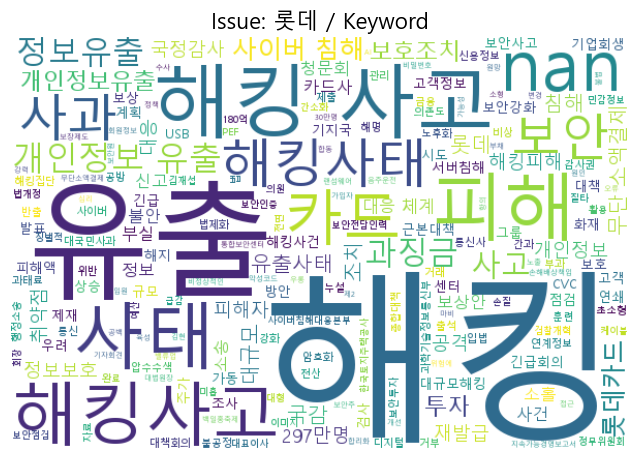

[Issue: 롯데] Top 3 Keywords


,Keyword,Count
0,해킹,285
1,유출,110
2,해킹 사고,29


In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
from matplotlib import rcParams

# ===============================
# 1) 폰트 설정 (윈도우용)
# ===============================
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

# ===============================
# 2) 불용어 + nan 제거용 유틸 함수
# ===============================
korean_stopwords = set([
    'nan', 'none', '', 'null',
    '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '를', '로', '에', '와', '한', '하다',
    '및', '에서', '도', '고', '으로', '?!', '.', ',', '(', ')', '“', '”', '-', '그', '저', '등', '더', '있는',
    '52g', '연구원', '모바일삼품권', '네이버', '부동산', 'CJ올리브영'
])

def clean_word(w):
    """nan, 공백, 불용어 모두 제거하는 통합 필터 함수"""
    if w is None:
        return None

    w = str(w).strip()

    if w == "" or w.lower() == "nan":
        return None

    if w.lower() in korean_stopwords:
        return None

    return w

# ===============================
# 3) 워드클라우드 & Top3 키워드 생성
# ===============================

issues = df_total_nodup['issue'].unique()

for issue in issues:

    sub_df = df_total_nodup[df_total_nodup['issue'] == issue]

    keyword_words = []

    # ----------------------------------------
    # keyword 컬럼 정규 처리
    # ----------------------------------------
    for k in sub_df['keyword']:

        # None, np.nan
        if pd.isna(k):
            continue

        k_str = str(k).strip()
        if k_str.lower() == "nan":
            continue

        # 리스트 형태
        if isinstance(k, list):
            for item in k:
                cleaned = clean_word(item)
                if cleaned:
                    keyword_words.append(cleaned)
            continue

        # 문자열이면서 리스트처럼 저장된 경우
        if isinstance(k, str):
            try:
                parsed = eval(k)
                # ['유출','nan'] 같은 경우
                if isinstance(parsed, list):
                    for item in parsed:
                        cleaned = clean_word(item)
                        if cleaned:
                            keyword_words.append(cleaned)
                else:
                    cleaned = clean_word(parsed)
                    if cleaned:
                        keyword_words.append(cleaned)
            except:
                cleaned = clean_word(k)
                if cleaned:
                    keyword_words.append(cleaned)

    # 최종 정제된 리스트
    cleaned_keywords = [clean_word(w) for w in keyword_words if clean_word(w)]

    # ----------------------------------------
    # 워드클라우드 출력
    # ----------------------------------------
    print(f"\n====== Issue: {issue} ======\n")

    if cleaned_keywords:
        text_keyword = " ".join(cleaned_keywords)

        # WordCloud 생성
        wc_keyword = WordCloud(
            font_path='malgun.ttf',
            background_color='white',
            width=600,
            height=400
        ).generate(text_keyword)

        plt.figure(figsize=(8, 6))
        plt.imshow(wc_keyword, interpolation='bilinear')
        plt.title(f"Issue: {issue} / Keyword", fontsize=16)
        plt.axis("off")
        plt.show()
    else:
        print(f"[Issue: {issue}] 사용할 키워드가 없습니다.")

    # ----------------------------------------
    # Top3 출력
    # ----------------------------------------
    keyword_counter = Counter(cleaned_keywords)
    top3 = keyword_counter.most_common(3)

    top3_df = pd.DataFrame(top3, columns=["Keyword", "Count"])
    print(f"[Issue: {issue}] Top 3 Keywords")
    display(top3_df)


In [24]:
import pandas as pd

# 파일 경로 지정
file_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result.xlsx"

# 엑셀 파일 불러오기
df = pd.read_excel(file_path)

# 'D' 컬럼에서 대괄호([, ])를 제거하고, 숫자로 변환
df['D'] = df['D'].astype(str).str.replace('[\[\]]', '', regex=True)
df['D'] = pd.to_numeric(df['D'], errors='coerce')

# 'D' 컬럼 값이 0인 행 제거
df = df[df['D'] != 0]

# 결과를 엑셀로 저장
save_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_nonzero.xlsx"
df.to_excel(save_path, index=False)
print(f"'D'가 0인 행 제거 후 저장 완료: {save_path}")


<>:10: SyntaxWarning: invalid escape sequence '\['
<>:10: SyntaxWarning: invalid escape sequence '\['
C:\Users\speec\AppData\Local\Temp\ipykernel_22580\3134200883.py:10: SyntaxWarning: invalid escape sequence '\['
  df['D'] = df['D'].astype(str).str.replace('[\[\]]', '', regex=True)


'D'가 0인 행 제거 후 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_nonzero.xlsx


In [30]:
import pandas as pd

# 파일 경로
file_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_nonzero.xlsx"

# 엑셀 파일 불러오기 (최대 5행만 미리 보기)
df = pd.read_excel(file_path)
print(df.columns)


Index(['issue', 'content_id', 'datetime', 'post_sentiment', 'post_s',
       'cmt_s_mean', 'abs_sent_gap', 'aligned_cnt_3h', 'aligned_cnt_6h',
       'aligned_cnt_9h', 'viewCount', 'likeCount', 'comment_cnt',
       'subscriberCount', '언론사', 'content', 'channel', 'title_or_text',
       'Event', 'Event_words', 'Cause', 'Cause_words', 'Impact',
       'Impact_words', 'Reaction', 'Reaction_words', 'Entity', 'Entity_words',
       'match_sum', 'channelTitle', 'R', 'S', 'L', 'Lnorm', 'E', 'T', 'entity',
       'keyword', 'label', 'D', 'Unnamed: 40'],
      dtype='object')


In [29]:
import pandas as pd

# 파일 경로 지정
input_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_nonzero.xlsx"
output_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_agg_3h.xlsx"

def aggregate_issue_3h(df_total_nodup, save_path=None):

    df = df_total_nodup.copy()

    # --------------------------------------------------------
    # 1️⃣ aligned_cnt_6h 타입 정리
    # --------------------------------------------------------
    if 'aligned_cnt_6h' in df.columns:
        if df['aligned_cnt_6h'].dtype == 'object':
            df['aligned_cnt_6h'] = pd.to_numeric(df['aligned_cnt_6h'], errors='coerce')

    # --------------------------------------------------------
    # 2️⃣ 불필요 컬럼 제거
    # --------------------------------------------------------
    drop_cols = [
        'subscriberCount', 'Event_words', 'channelTitle',
        'content_id', 'post_sentiment', '언론사', 'content', 'title_or_text',
        'R', 'S', 'L', 'E', 'T','entity','label','keyword'
    ]
    df = df.drop(columns=drop_cols, errors='ignore')

    # --------------------------------------------------------
    # 3️⃣ datetime 변환 + 3시간 블록 생성
    # --------------------------------------------------------
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df = df.sort_values('datetime')
    df['datetime_3h'] = df['datetime'].dt.floor('3h')

    # --------------------------------------------------------
    # 4️⃣ Lflag 생성
    # --------------------------------------------------------
    df['Lflag'] = df['channel'].apply(
        lambda x: 1 if str(x).strip() in ['네이버', '뉴스', '커뮤니티'] else 0
    )

    # --------------------------------------------------------
    # 5️⃣ 집계 컬럼 구분
    # --------------------------------------------------------
    sum_cols = [
        'viewCount', 'likeCount', 'comment_cnt',
        'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h',
        'match_sum'
    ]
    mean_cols = ['abs_sent_gap','D']

    sum_cols_valid = [c for c in sum_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    mean_cols_valid = [c for c in mean_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    # Entity, Event, Cause, Impact, Reaction, Lflag 도 sum으로 변경
    extra_sum_cols = [c for c in ['Entity', 'Event', 'Cause', 'Impact', 'Reaction', 'Lflag'] if c in df.columns]
    sum_cols_valid = sum_cols_valid + extra_sum_cols

    # --------------------------------------------------------
    # 6️⃣ 그룹핑 준비: issue × datetime_3h × channel
    # --------------------------------------------------------
    agg_dict = {}
    agg_dict.update({c: 'sum' for c in sum_cols_valid})
    agg_dict.update({c: 'mean' for c in mean_cols_valid})
    agg_dict.update({'datetime': 'count'})

    df_grouped = (
        df.groupby(['issue', 'datetime_3h', 'channel'])
          .agg(agg_dict)
          .reset_index()
          .rename(columns={'datetime': 'count'})
    )

    # --------------------------------------------------------
    # 7️⃣ Lnorm 조건부 평균 (트위터·블로그 제외)
    # --------------------------------------------------------
    if 'Lnorm' in df.columns:
        lnorm_data = (
            df[~df['channel'].isin(['트위터', '블로그'])]
            .groupby(['issue', 'datetime_3h', 'channel'])['Lnorm']
            .mean()
            .reset_index()
        )

        df_grouped = pd.merge(
            df_grouped,
            lnorm_data,
            on=['issue', 'datetime_3h', 'channel'],
            how='left',
            suffixes=('', '_filtered')
        )

        if 'Lnorm_filtered' in df_grouped.columns:
            df_grouped['Lnorm'] = df_grouped['Lnorm_filtered']
            df_grouped = df_grouped.drop(columns=['Lnorm_filtered'])

    # --------------------------------------------------------
    # 8️⃣ 엑셀로 저장 (옵션)
    # --------------------------------------------------------
    if save_path is not None:
        df_grouped.to_excel(save_path, index=False)
        print(f"집계 결과가 저장되었습니다: {save_path}")

    return df_grouped

# 파일 열고 함수 적용&저장
df_input = pd.read_excel(input_path)
aggregate_issue_3h(df_input, save_path=output_path)


집계 결과가 저장되었습니다: C:\Users\speec\OneDrive\Desktop\PoC_v2\전처리\total_merged_result_D_agg_3h.xlsx


,issue,datetime_3h,channel,viewCount,likeCount,comment_cnt,aligned_cnt_3h,aligned_cnt_6h,aligned_cnt_9h,match_sum,Entity,Event,Cause,Impact,Reaction,Lflag,abs_sent_gap,D,count,Lnorm
0,GS,2024-12-26 12:00:00,blog,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1,0,0,0,0,NaN,NaN,1,NaN
1,GS,2025-01-02 09:00:00,blog,0.0,0.0,0.0,0.0,0.0,0.0,6,2,3,1,0,0,0,NaN,1.0000,1,NaN
2,GS,2025-01-03 06:00:00,blog,0.0,0.0,0.0,0.0,0.0,0.0,4,1,2,0,0,1,0,NaN,0.9760,1,NaN
3,GS,2025-01-05 18:00:00,twitter,0.0,0.0,0.0,0.0,0.0,0.0,16,6,8,1,0,1,0,NaN,0.9115,4,NaN
4,GS,2025-01-05 21:00:00,twitter,0.0,0.0,0.0,0.0,0.0,0.0,24,12,12,0,0,0,0,NaN,0.9520,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,롯데,2025-10-16 15:00:00,네이버,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1,0,0,0,2,0.5,0.4000,2,0.117195
1351,롯데,2025-10-16 18:00:00,네이버,0.0,0.0,0.0,0.0,0.0,0.0,5,3,1,1,0,0,2,1.0,0.9970,2,0.246655
1352,롯데,2025-10-16 21:00:00,네이버,0.0,0.0,0.0,0.0,0.0,0.0,6,4,1,1,0,0,3,1.0,0.9960,3,0.127261
1353,롯데,2025-10-17 00:00:00,네이버,0.0,0.0,0.0,0.0,0.0,0.0,3,0,1,1,0,1,2,1.0,0.9765,2,0.202300


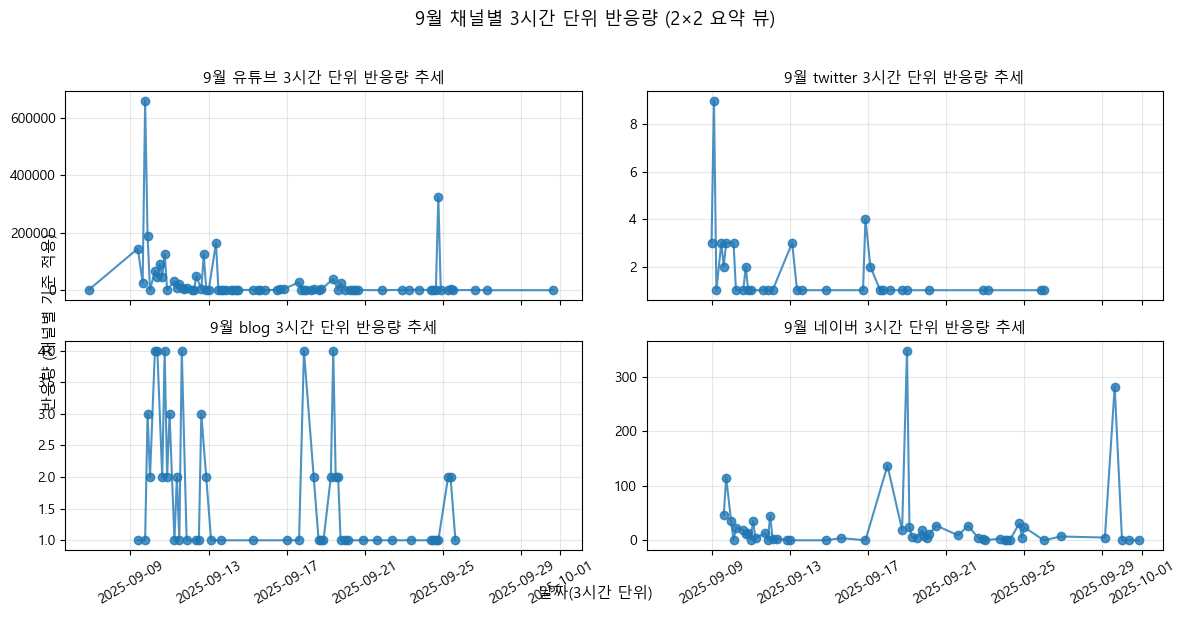

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
from matplotlib import font_manager, rc

# -------------------------------------------
# 한글 폰트 설정
# -------------------------------------------
def set_korean_font():
    import platform
    system = platform.system()
    if system == 'Windows':
        font_name = 'Malgun Gothic'
    elif system == 'Darwin':
        font_name = 'AppleGothic'
    else:
        font_name = 'NanumGothic'
        if font_name not in set(f.name for f in font_manager.fontManager.ttflist):
            import subprocess
            subprocess.call("apt-get install -y fonts-nanum", shell=True)
            matplotlib.font_manager._rebuild()
    rc('font', family=font_name)
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# -------------------------------------------
# 1️⃣ 데이터 불러오기
# -------------------------------------------
excel_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_3시간_단위_채널별_집계_withCount.xlsx"
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"지정한 파일을 찾을 수 없습니다: {excel_path}")

df = pd.read_excel(excel_path)

# datetime 변환
df['datetime_3h'] = pd.to_datetime(df['datetime_3h'], errors='coerce')

# -------------------------------------------
# 2️⃣ 채널별 반응량 계산 로직
# -------------------------------------------
def calc_react(row):
    ch = str(row['channel']).strip().lower()
    if ch in ['twitter', '트위터', 'blog', '블로그']:
        return row.get('count', 0)
    elif ch in ['네이버', 'naver']:
        return row.get('comment_cnt', 0)
    else:
        return row.get('viewCount', 0) + row.get('likeCount', 0) + row.get('comment_cnt', 0)

df['total_react'] = df.apply(calc_react, axis=1)

# -------------------------------------------
# 3️⃣ 9월 데이터만 필터링 후 정렬
# -------------------------------------------
df_september = df[df['datetime_3h'].dt.month == 9].copy()
df_september = df_september.sort_values('datetime_3h')

# -------------------------------------------
# 4️⃣ 2행×2열 레이아웃으로 시각화
# -------------------------------------------
channels = df_september['channel'].unique()
n_channels = len(channels)

# 최대 4개 기준, 2행×2열 배치
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 6), sharex=True)
axes = axes.flatten()  # 2D → 1D 배열로 변환

for idx, ch in enumerate(channels[:rows * cols]):  # 4개까지만 표시
    temp = df_september[df_september['channel'] == ch]
    axes[idx].plot(temp['datetime_3h'], temp['total_react'], marker='o', alpha=0.8, linewidth=1.5)
    axes[idx].set_title(f"9월 {ch} 3시간 단위 반응량 추세", fontsize=11)
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=30)

# 남는 subplot은 숨김
for ax in axes[n_channels:]:
    ax.set_visible(False)

# 공통 라벨
fig.text(0.5, 0.04, '날짜(3시간 단위)', ha='center', fontsize=11)
fig.text(0.04, 0.5, '반응량 (채널별 기준 적용)', va='center', rotation='vertical', fontsize=11)

fig.suptitle("9월 채널별 3시간 단위 반응량 (2×2 요약 뷰)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


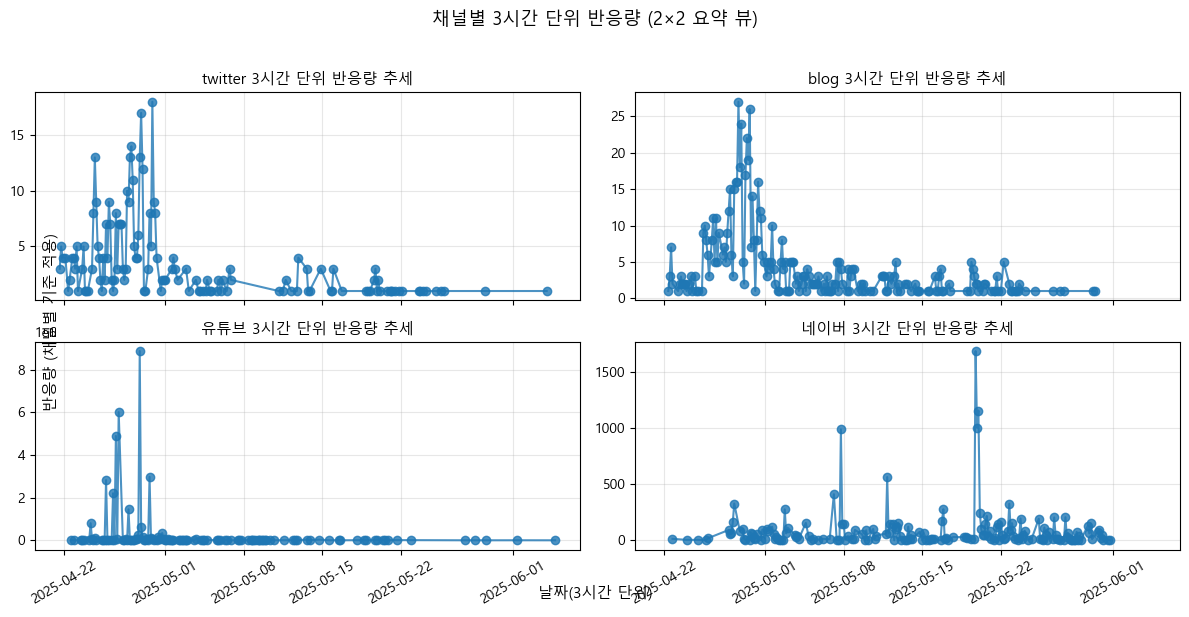

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
from matplotlib import font_manager, rc

# -------------------------------------------
# 한글 폰트 설정
# -------------------------------------------
def set_korean_font():
    import platform
    system = platform.system()
    if system == 'Windows':
        font_name = 'Malgun Gothic'
    elif system == 'Darwin':
        font_name = 'AppleGothic'
    else:
        font_name = 'NanumGothic'
        if font_name not in set(f.name for f in font_manager.fontManager.ttflist):
            import subprocess
            subprocess.call("apt-get install -y fonts-nanum", shell=True)
            matplotlib.font_manager._rebuild()
    rc('font', family=font_name)
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# -------------------------------------------
# 1️⃣ 데이터 불러오기
# -------------------------------------------
excel_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\SKT_3시간_단위_채널별_집계_withCount.xlsx"
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"지정한 파일을 찾을 수 없습니다: {excel_path}")

df = pd.read_excel(excel_path)

# datetime 변환
df['datetime_3h'] = pd.to_datetime(df['datetime_3h'], errors='coerce')

# -------------------------------------------
# 2️⃣ 채널별 반응량 계산 로직
# -------------------------------------------
def calc_react(row):
    ch = str(row['channel']).strip().lower()
    if ch in ['twitter', '트위터', 'blog', '블로그']:
        return row.get('count', 0)
    elif ch in ['네이버', 'naver']:
        return row.get('comment_cnt', 0)
    else:
        return row.get('viewCount', 0) + row.get('likeCount', 0) + row.get('comment_cnt', 0)

df['total_react'] = df.apply(calc_react, axis=1)

# -------------------------------------------
# # 3️⃣ 9월 데이터만 필터링 후 정렬
# # -------------------------------------------
# 9월로 한정하지 않고 전체 데이터 사용
df_sorted = df.sort_values('datetime_3h')

# -------------------------------------------
# 4️⃣ 2행×2열 레이아웃으로 시각화
# -------------------------------------------
channels = df_sorted['channel'].unique()
n_channels = len(channels)

# 최대 4개 기준, 2행×2열 배치
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 6), sharex=True)
axes = axes.flatten()  # 2D → 1D 배열로 변환

for idx, ch in enumerate(channels[:rows * cols]):  # 4개까지만 표시
    temp = df[df['channel'] == ch]
    axes[idx].plot(temp['datetime_3h'], temp['total_react'], marker='o', alpha=0.8, linewidth=1.5)
    axes[idx].set_title(f"{ch} 3시간 단위 반응량 추세", fontsize=11)
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=30)

# 남는 subplot은 숨김
for ax in axes[n_channels:]:
    ax.set_visible(False)

# 공통 라벨
fig.text(0.5, 0.04, '날짜(3시간 단위)', ha='center', fontsize=11)
fig.text(0.04, 0.5, '반응량 (채널별 기준 적용)', va='center', rotation='vertical', fontsize=11)

fig.suptitle("채널별 3시간 단위 반응량 (2×2 요약 뷰)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


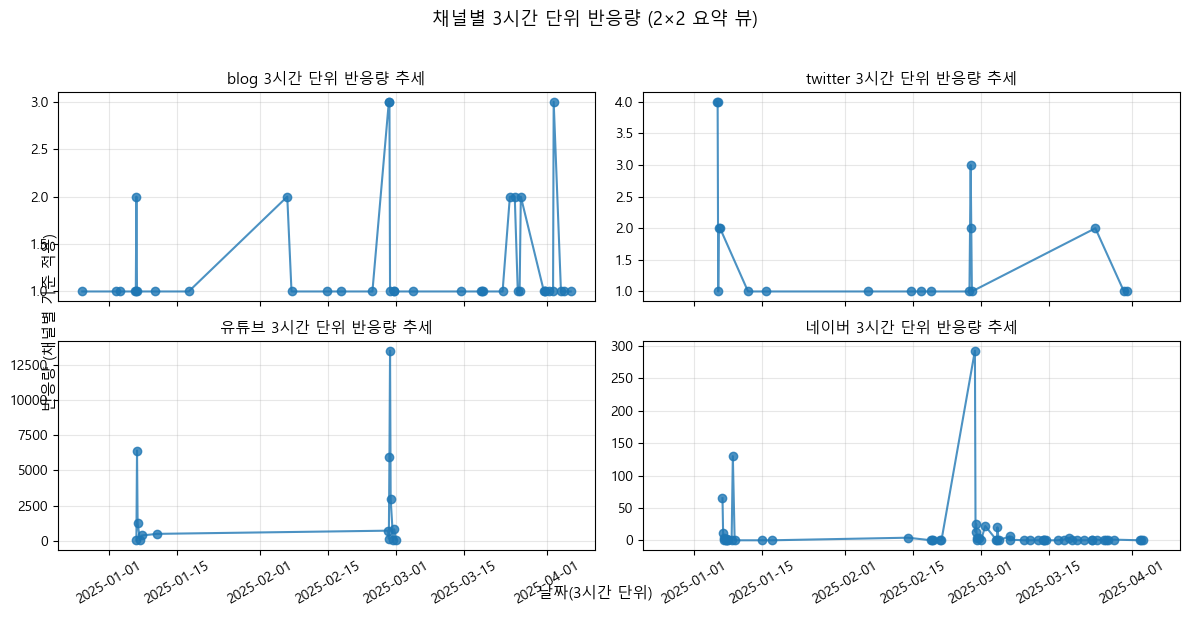

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
from matplotlib import font_manager, rc

# -------------------------------------------
# 한글 폰트 설정
# -------------------------------------------
def set_korean_font():
    import platform
    system = platform.system()
    if system == 'Windows':
        font_name = 'Malgun Gothic'
    elif system == 'Darwin':
        font_name = 'AppleGothic'
    else:
        font_name = 'NanumGothic'
        if font_name not in set(f.name for f in font_manager.fontManager.ttflist):
            import subprocess
            subprocess.call("apt-get install -y fonts-nanum", shell=True)
            matplotlib.font_manager._rebuild()
    rc('font', family=font_name)
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# -------------------------------------------
# 1️⃣ 데이터 불러오기
# -------------------------------------------
excel_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_3시간_단위_채널별_집계_withCount.xlsx"
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"지정한 파일을 찾을 수 없습니다: {excel_path}")

df = pd.read_excel(excel_path)

# datetime 변환
df['datetime_3h'] = pd.to_datetime(df['datetime_3h'], errors='coerce')

# -------------------------------------------
# 2️⃣ 채널별 반응량 계산 로직
# -------------------------------------------
def calc_react(row):
    ch = str(row['channel']).strip().lower()
    if ch in ['twitter', '트위터', 'blog', '블로그']:
        return row.get('count', 0)
    elif ch in ['네이버', 'naver']:
        return row.get('comment_cnt', 0)
    else:
        return row.get('viewCount', 0) + row.get('likeCount', 0) + row.get('comment_cnt', 0)

df['total_react'] = df.apply(calc_react, axis=1)

# -------------------------------------------
# # 3️⃣ 9월 데이터만 필터링 후 정렬
# # -------------------------------------------
# 9월로 한정하지 않고 전체 데이터 사용
df_sorted = df.sort_values('datetime_3h')

# -------------------------------------------
# 4️⃣ 2행×2열 레이아웃으로 시각화
# -------------------------------------------
channels = df_sorted['channel'].unique()
n_channels = len(channels)

# 최대 4개 기준, 2행×2열 배치
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 6), sharex=True)
axes = axes.flatten()  # 2D → 1D 배열로 변환

for idx, ch in enumerate(channels[:rows * cols]):  # 4개까지만 표시
    temp = df[df['channel'] == ch]
    axes[idx].plot(temp['datetime_3h'], temp['total_react'], marker='o', alpha=0.8, linewidth=1.5)
    axes[idx].set_title(f"{ch} 3시간 단위 반응량 추세", fontsize=11)
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=30)

# 남는 subplot은 숨김
for ax in axes[n_channels:]:
    ax.set_visible(False)

# 공통 라벨
fig.text(0.5, 0.04, '날짜(3시간 단위)', ha='center', fontsize=11)
fig.text(0.04, 0.5, '반응량 (채널별 기준 적용)', va='center', rotation='vertical', fontsize=11)

fig.suptitle("채널별 3시간 단위 반응량 (2×2 요약 뷰)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


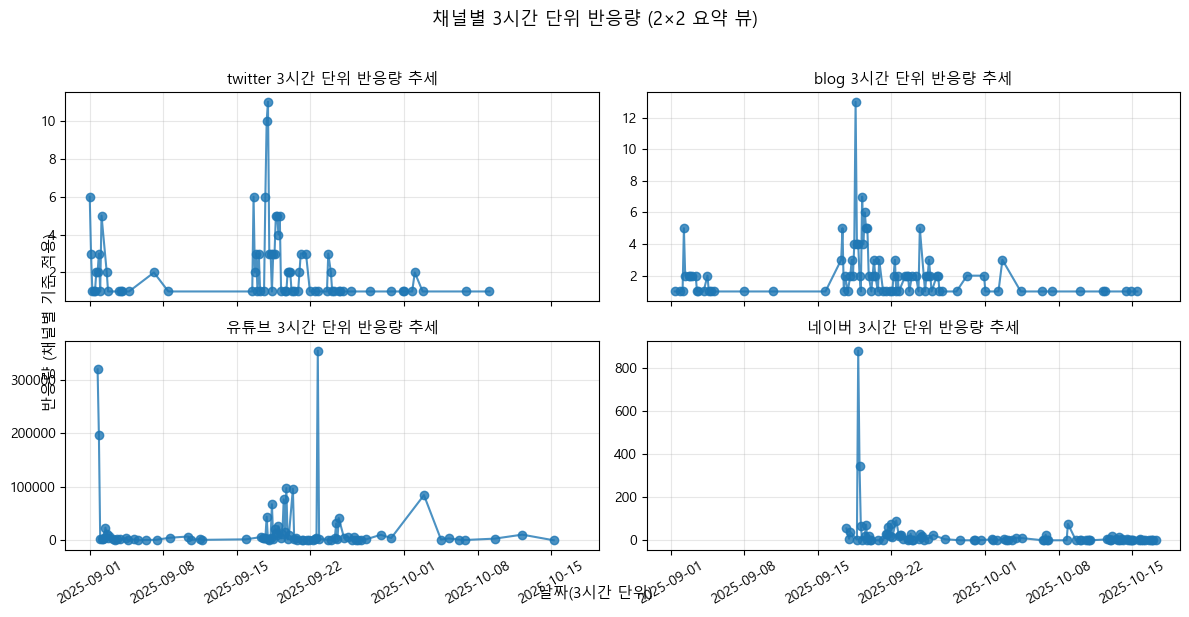

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib
from matplotlib import font_manager, rc

# -------------------------------------------
# 한글 폰트 설정
# -------------------------------------------
def set_korean_font():
    import platform
    system = platform.system()
    if system == 'Windows':
        font_name = 'Malgun Gothic'
    elif system == 'Darwin':
        font_name = 'AppleGothic'
    else:
        font_name = 'NanumGothic'
        if font_name not in set(f.name for f in font_manager.fontManager.ttflist):
            import subprocess
            subprocess.call("apt-get install -y fonts-nanum", shell=True)
            matplotlib.font_manager._rebuild()
    rc('font', family=font_name)
    plt.rcParams['axes.unicode_minus'] = False

set_korean_font()

# -------------------------------------------
# 1️⃣ 데이터 불러오기
# -------------------------------------------
excel_path = r"C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_3시간_단위_채널별_집계_withCount.xlsx"
if not os.path.exists(excel_path):
    raise FileNotFoundError(f"지정한 파일을 찾을 수 없습니다: {excel_path}")

df = pd.read_excel(excel_path)

# datetime 변환
df['datetime_3h'] = pd.to_datetime(df['datetime_3h'], errors='coerce')

# -------------------------------------------
# 2️⃣ 채널별 반응량 계산 로직
# -------------------------------------------
def calc_react(row):
    ch = str(row['channel']).strip().lower()
    if ch in ['twitter', '트위터', 'blog', '블로그']:
        return row.get('count', 0)
    elif ch in ['네이버', 'naver']:
        return row.get('comment_cnt', 0)
    else:
        return row.get('viewCount', 0) + row.get('likeCount', 0) + row.get('comment_cnt', 0)

df['total_react'] = df.apply(calc_react, axis=1)

# -------------------------------------------
# # 3️⃣ 9월 데이터만 필터링 후 정렬
# # -------------------------------------------
# 9월로 한정하지 않고 전체 데이터 사용
df_sorted = df.sort_values('datetime_3h')

# -------------------------------------------
# 4️⃣ 2행×2열 레이아웃으로 시각화
# -------------------------------------------
channels = df_sorted['channel'].unique()
n_channels = len(channels)

# 최대 4개 기준, 2행×2열 배치
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 6), sharex=True)
axes = axes.flatten()  # 2D → 1D 배열로 변환

for idx, ch in enumerate(channels[:rows * cols]):  # 4개까지만 표시
    temp = df[df['channel'] == ch]
    axes[idx].plot(temp['datetime_3h'], temp['total_react'], marker='o', alpha=0.8, linewidth=1.5)
    axes[idx].set_title(f"{ch} 3시간 단위 반응량 추세", fontsize=11)
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=30)

# 남는 subplot은 숨김
for ax in axes[n_channels:]:
    ax.set_visible(False)

# 공통 라벨
fig.text(0.5, 0.04, '날짜(3시간 단위)', ha='center', fontsize=11)
fig.text(0.04, 0.5, '반응량 (채널별 기준 적용)', va='center', rotation='vertical', fontsize=11)

fig.suptitle("채널별 3시간 단위 반응량 (2×2 요약 뷰)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()
